In [17]:
# configure path to include the python files
import sys, os, subprocess

nb_path = !pwd
nb_path = nb_path[0]

lib_path = os.path.abspath(os.path.join(nb_path, '..', 'openh264', 'info_shipout'))
if lib_path not in sys.path:
    sys.path.append(lib_path)

# import slice
from slice_pb2 import Slice

In [16]:
# extract encoding parameters

bin_path = os.path.abspath(os.path.join(nb_path, '..', 'bin'))
h264_ext_bin = os.path.join(bin_path, 'h264dec_ext_info')
if not os.path.exists(h264_ext_bin):
    raise FileNotFoundError(f'cannot locate the binary file "{h264_ext_bin}", was it built?')

# the example video
video_fn = os.path.join(nb_path, 'bunny.mp4')
h264_fn = os.path.join(nb_path, os.path.splitext(video_fn)[0] + '.h264')

# first, extract h264 from the mp4 file using ffmpeg
cp = subprocess.run(
        ['ffmpeg', '-y', '-i', video_fn, '-vcodec', 'copy', '-an', 
        '-bsf:v', 'h264_mp4toannexb', h264_fn],
        check=True
    )

# use the extractor to acquire encoding parameters
yuv_fn = os.path.join(nb_path, 'bunny.yuv') # YUV frames
ep_fn = os.path.join(nb_path, 'bunny.msg') # encoding parameters

cp = subprocess.run(
        [h264_ext_bin, h264_fn, '--yuv_out', yuv_fn, '--info_out', ep_fn, '--n_threads', '0'],
        # for now, only setting threads to 0 is allowed; using other values can result in 
        # unexpected behaviors
        check=True
    )

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1602879523915/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1602879523915/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7.

------------------------------------------------------


In [23]:
# read YUV and encoding parameters
import struct
import os
import skimage.transform, skimage.color
import numpy as np

def msg_file_iter(fn):
    with open(fn, 'rb') as infile:
        file_length = os.stat(fn)
        while infile.tell() < file_length.st_size:
            length_bytes = infile.read(4)
            length = struct.unpack('<I', length_bytes)[0]
            yield infile.read(length)


def read_yuv_data(width, height, frame_num, fn):
    file_stat = os.stat(fn)
    frame_size = width * height * 1.5
    frame_size = int(frame_size)
    u_max = 0.436
    v_max = 0.615
    with open(fn, 'rb') as infile:
        infile.seek(frame_num * frame_size)
        y = np.frombuffer(infile.read(width * height), dtype=np.uint8).reshape((height, width))
        u = np.frombuffer(infile.read(width * height // 4), dtype=np.uint8).reshape((height // 2, width // 2))
        v = np.frombuffer(infile.read(width * height // 4), dtype=np.uint8).reshape((height // 2, width // 2))
        u = skimage.transform.rescale(u, 2.0, 1, anti_aliasing=False)
        v = skimage.transform.rescale(v, 2.0, 1, anti_aliasing=False)
        y = skimage.img_as_float32(y)

        u = (u * 2 * u_max) - u_max
        v = (v * 2 * v_max) - v_max

        yuv = np.dstack([y, u, v])
        rgb = skimage.color.yuv2rgb(yuv)
    return rgb


def read_msg(fn):
    info_iter = msg_file_iter(fn)
    for info_bytes in info_iter:
        slice = Slice()
        slice.ParseFromString(info_bytes)
        yield slice

In [72]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np


# create encoding parameters iterator
encoding_parameters_iter = read_msg(ep_fn)
# read the second slice
next(encoding_parameters_iter)
sl = next(encoding_parameters_iter)
width, height = sl.width, sl.height
# read the second frame
rgb_frame = read_yuv_data(width, height, 1, yuv_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'The Second Decoded Frame')

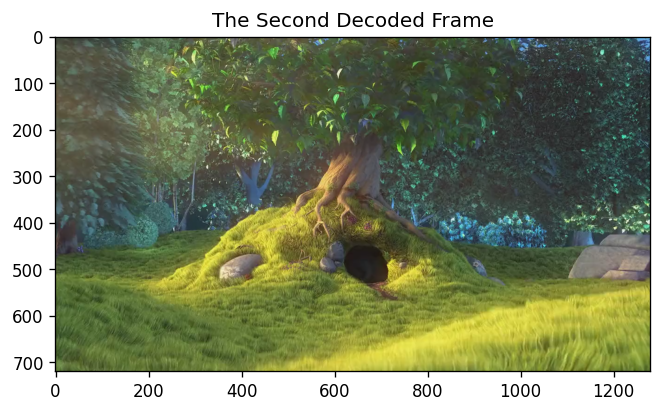

In [65]:
plt.imshow(rgb_frame)
plt.title('The Second Decoded Frame')

In [66]:
# now, visualize the encoding parameters

# first we need to get the size of the macroblocks from the enums

import re
from slice_pb2 import MacroblockType

# parse the size of macroblocks from the enum names
mb_size_re = re.compile('([0-9]{1,2})x([0-9]{1,2})')
mb_size_dict = dict()
for key, val in MacroblockType.items():
    search_result = mb_size_re.search(key)
    if search_result is not None:
        size1 = int(search_result.group(1))
        size2 = int(search_result.group(2))
        mb_size_dict[key] = (size1, size2)
    else:
        mb_size_dict[key] = (16, 16)

# show some entires
for key in list(mb_size_dict.keys())[:10]:
    print(f'{key}={mb_size_dict[key]}')

MB_TYPE_PLACEHOLDER=(16, 16)
MB_TYPE_INTRA4x4=(4, 4)
MB_TYPE_INTRA16x16=(16, 16)
MB_TYPE_INTRA8x8=(8, 8)
MB_TYPE_16x16=(16, 16)
MB_TYPE_16x8=(16, 8)
MB_TYPE_8x16=(8, 16)
MB_TYPE_8x8=(8, 8)
MB_TYPE_8x8_REF0=(8, 8)
MB_TYPE_SKIP=(16, 16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Macroblock Partition and Type')

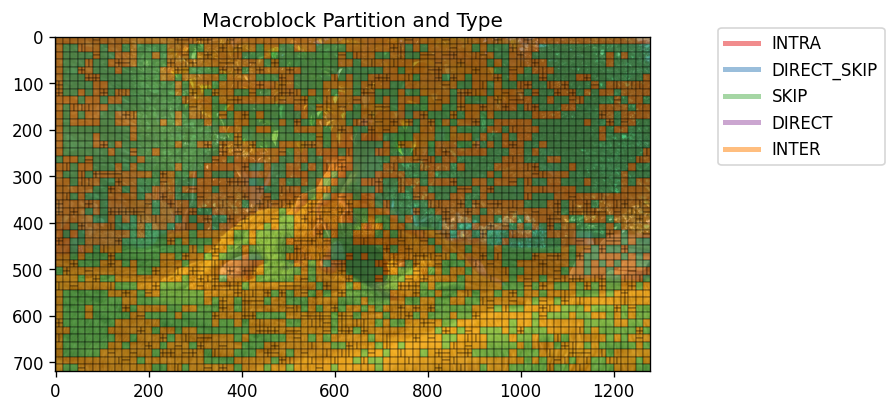

In [75]:
# now, begin the visualization
plt.imshow(rgb_frame)
ax = plt.gca()

mb_color_cycle = plt.get_cmap('Set1')
mb_alpha = 0.5
mb_colors = np.asarray([mb_color_cycle(i) for i in range(5)])
mb_colors[:, 3] = mb_alpha
mb_labels = ['INTRA', 'DIRECT_SKIP', 'SKIP', 'DIRECT', 'INTER']
line_color = 'black'
line_width = 0.2

for mb in sl.mbs:
    mb_type = MacroblockType.Name(mb.type)
    mb_size = mb_size_dict[mb_type]

    mb_label_index = None

    # determine the color
    if 'INTRA' in mb_type:
        mb_label_index = 0
    elif 'SKIP' in mb_type and 'DIRECT' in mb_type:
        mb_label_index = 1
    elif 'SKIP' in mb_type:
        mb_label_index = 2
    elif 'DIRECT' in mb_type:
        mb_label_index = 3
    else:
        mb_label_index = 4

    color = mb_colors[mb_label_index]
    
    # compute the lower left corner of the macroblock
    mb_x = mb.x * 16
    mb_y = mb.y * 16

    patches = []

    if mb_size == (16, 16):
        patches.append(Rectangle((mb_x, mb_y), 16, 16, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (8, 16):
        patches.append(Rectangle((mb_x, mb_y), 8, 16, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
        patches.append(Rectangle((mb_x + 8, mb_y), 8, 16, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (16, 8):
        patches.append(Rectangle((mb_x, mb_y), 16, 8, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
        patches.append(Rectangle((mb_x, mb_y+8), 16, 8, 
            facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (8, 8):
        for i in range(2):
            for j in range(2):
                patches.append(Rectangle((mb_x+i*8, mb_y+j*8), 8, 8, 
                    facecolor=color, edgecolor=line_color, linewidth=line_width))
    elif mb_size == (4,4):
        for i in range(4):
            for j in range(4):
                patches.append(Rectangle((mb_x+i*4, mb_y+j*4), 4, 4, 
                    facecolor=color, edgecolor=line_color, linewidth=line_width))
    else:
        raise ValueError(f'unsupported macroblock size {mb_size}')

    for patch in patches:
        ax.add_patch(patch)

# generate the legend
custom_legends = [Line2D([0], [0], color=x, lw=3) for x in mb_colors]
plt.legend(custom_legends, mb_labels, bbox_to_anchor=(1.1, 1.05))
plt.title('Macroblock Partition and Type')